The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
MSE SE:  0.14613490337484739
MSE SE:  0.14322961114186128
MSE SE:  0.14019969136377436
MSE SE:  0.13704648917086495
MSE SE:  0.1337688861054362
MSE SE:  0.130363315595324
MSE SE:  0.12682332856525277
MSE SE:  0.12313940873124261
MSE SE:  0.11929814906979709
MSE SE:  0.11528095882759756
MSE SE:  0.11106255955346629
MSE SE:  0.10660771623089373
MSE SE:  0.10186592911158744
MSE SE:  0.09676189717725861
MSE SE:  0.09117437518452232
MSE SE:  0.08488774806572606
MSE SE:  0.07743896512246709
MSE SE:  0.06732845469163616
MSE SE:  1.0440811099089688e-07
MSE SE:  1.0440993155509993e-07
MSE SE:  1.0441175211930296e-07
Delta:  0.1
Delta:  0.2
Delta:  0.30000000000000004
Delta:  0.4
Delta:  0.5
Delta:  0.6
Delta:  0.7000000000000001
Delta:  0.8
Delta:  0.9
Delta:  1.0
Delta:  1.1
Delta:  1.2000000000000002
Delta:  1.3000000000000003
Delta:  1.4000000000000001
Delta:  1.5000000000000002
Delta:  1.6
Delta:  1.7000

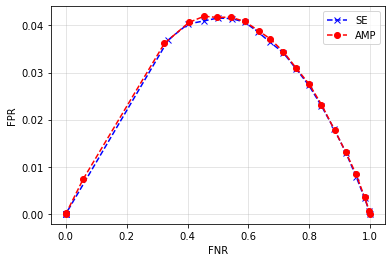

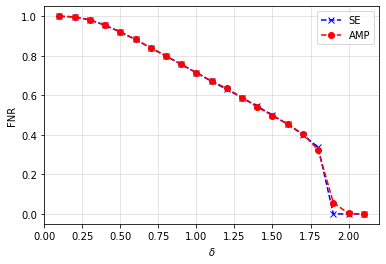

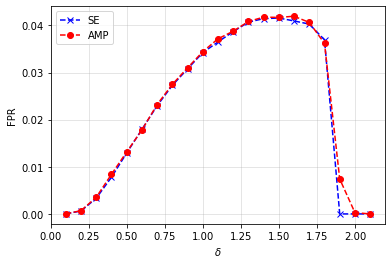

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Nov  6 14:56:53 2023

@author: pp423
"""
%load_ext autoreload
%autoreload 2

import numpy as np
import tikzplotlib
import matplotlib.pyplot as plt
from ipynb.fs.full.amp_qgt import sub_amp_bayes, amp_bayes, create_beta, Xiid_to_Xtilde, y_iid_to_y_iid_tilde, g_in_bayes
from ipynb.fs.full.se_qgt import state_ev_iid_disc, state_ev_iid_disc_sub, fpr_fnr, est_error_se_iid, quantize
from numpy.random import binomial

#----------------Figure 6a------------------------------------------------------
theta = 0.8
#number of subjects
p = 5000
# defective chance
noise = 0

run_no = 100
ITL = int(2*(1-theta)/theta*p**theta)


delta_array = np.linspace(0.1, 2.1, num=21)

se_delta_array = np.linspace(0.1, 2.1, num=21)

nc_array_av = []
nc_array_std = []
se_nc_array = []

#State Evolution
fpr_se_01 = np.ones(len(se_delta_array))
fnr_se_01 = np.ones(len(se_delta_array))




for i in range(len(se_delta_array)):
    delta = se_delta_array[i]
    #defective chance
    nu = p**(theta-1)
    n_samples = 1000000
    beta_0 = create_beta(nu, n_samples)
    tau, mse_pred, _, tau_array_se =  state_ev_iid_disc_sub(delta, 200, nu, p, theta)
    print("MSE SE: ", mse_pred)
    tau_G = tau*np.random.randn(n_samples)
    beta_est = g_in_bayes(beta_0 + tau_G, tau**2, nu)
    beta_q = quantize(beta_est, 0.5)
    fpr_se_01[i], fnr_se_01[i], _ = fpr_fnr(beta_q, beta_0)
    
fpr_runs_01 = np.ones((run_no, len(delta_array)))*5
fnr_runs_01 = np.ones((run_no, len(delta_array)))*5    
    
for i in range(len(delta_array)):
    delta = delta_array[i]
    #defective chance
    nu = p**(theta-1)
    print("Delta: ", delta)
    #number of tests
    n = int(delta*nu*p)
    
    mse_runs = []
    nc_runs = []
    
    #IID
    for run in range(run_no):
        beta_0 = create_beta(nu, p)
    
        t = 100
        #chance of inclusion in a test
        alpha = 0.5
        #if(run % 50 ==0):
        #    print("Run: ", run)
            
        X = binomial(1, alpha, (n,p))
        y = np.dot(X, beta_0)
        
        #AMP
        X_tilde = Xiid_to_Xtilde(X, alpha)
        
        defect_no = np.sum(beta_0)
        
        y_tilde = y_iid_to_y_iid_tilde(y, alpha, nu, n, p, defect_no)
        X_tilde_T = np.transpose(X_tilde)
        beta, mse_pred, tau_array, error_norm_array, nc_array = sub_amp_bayes(X_tilde, X_tilde_T, y_tilde, t, nu, beta_0, theta, delta)
        norm_correl = (np.dot(beta, beta_0)/(np.linalg.norm(beta)*np.linalg.norm(beta_0)))**2
        
        nc_runs.append(norm_correl)
        
        beta_amp_q = quantize(beta, 0.5)
        fpr_runs_01[run, i], fnr_runs_01[run, i], _ = fpr_fnr(beta_amp_q, beta_0)
        

    nc_array_av.append(np.average(nc_runs))
    nc_array_std.append(np.std(nc_runs))
    fpr_amp_01 = np.average(fpr_runs_01, axis = 0)
    fnr_amp_01 = np.average(fnr_runs_01, axis = 0)
print(fpr_amp_01, fnr_amp_01, fnr_se_01, fpr_se_01)
    
plt.figure()
plt.plot(fnr_se_01, fpr_se_01, marker='x', label=r'SE', linestyle='dashed', color='blue')
plt.plot(fnr_amp_01, fpr_amp_01, marker='o', label=r'AMP', linestyle='dashed', color='red')
plt.grid(alpha=0.4)
plt.legend()
plt.ylabel('FPR')
plt.xlabel(r'FNR')
#tikzplotlib.save("pool_fig6a.tex")

plt.figure()
plt.plot(se_delta_array, fnr_se_01, marker='x', label=r'SE', linestyle='dashed', color='blue')
plt.plot(delta_array, fnr_amp_01, marker='o', label=r'AMP', linestyle='dashed', color='red')
plt.grid(alpha=0.4)
plt.legend()
plt.ylabel('FNR')
plt.xlabel(r'$\delta$')

plt.figure()
plt.plot(se_delta_array, fpr_se_01, marker='x', label=r'SE', linestyle='dashed', color='blue')
plt.plot(delta_array, fpr_amp_01, marker='o', label=r'AMP', linestyle='dashed', color='red')
plt.grid(alpha=0.4)
plt.legend()
plt.ylabel('FPR')
plt.xlabel(r'$\delta$')
print(delta_array)
